In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import datetime
import locale

locale.setlocale(locale.LC_TIME, "ru_RU") 

kpi_vpp_df = (pd.read_csv("../input/h_1_kpi_vpp.csv")
                .rename(columns={"План сотрудника": "employePlan", "Факт сотрудника": "employeResult", 
                                 "% вып-я": "percentage", "Число_чеков": "numberOfChecks", "Ср.чек": "avgCheck",
                                 "месяц": "date"})
                .assign(date = lambda x: x.date.apply(lambda el: datetime.datetime.strptime(el, "%b.%y")))
                .assign(employePlan = lambda x: x.employePlan.apply(lambda el: float(str(el).replace(" ", ''))))
                .assign(employeResult = lambda x: x.employeResult.apply(lambda el: float(str(el).replace(" ", ''))))
                .assign(percentage = lambda x: x.percentage.apply(lambda el: float(str(el).replace(",", ".")) if el != "#ДЕЛ/0!" else float("nan")))
                .assign(numberOfChecks = lambda x: x.numberOfChecks.apply(lambda el: int(el)))
                .assign(avgCheck = lambda x: x.avgCheck.apply(lambda el: float(str(el).replace(" ", '').replace(',', '')) if el != "/0" else float("nan")))
             ).dropna(axis=0, subset=["employePlan", "percentage", "avgCheck"])

In [4]:
kpi_vpp_df.isnull().any()

uid               False
employePlan       False
employeResult     False
percentage        False
numberOfChecks    False
avgCheck          False
date              False
dtype: bool

In [5]:
kpi_vpp_df.head(1)

,uid,employePlan,employeResult,percentage,numberOfChecks,avgCheck,date
0,u48,186000.0,115180.0,61.92,18,6399.0,2013-04-01


In [6]:
kpi_vpp_df.shape

(6323, 7)

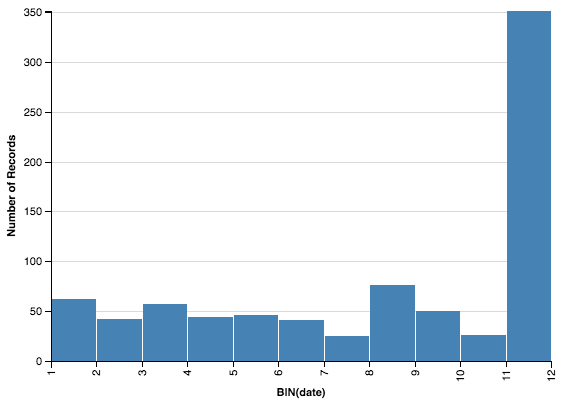

In [7]:
from altair import Chart, X, Y, Bin

Chart(kpi_vpp_df.groupby("uid")["date"].count().reset_index()).mark_bar().encode(
    x=X("date", bin=Bin(maxbins=11.0)),
    y="count(*)"
)

In [8]:
kpi_vpp_df.groupby("uid")["date"].count().reset_index().describe()

,date
count,820.000000
mean,7.710976
std,3.585090
min,1.000000
25%,4.750000
50%,9.000000
75%,11.000000
max,11.000000


Оставим в обучающей выборке только тех людей о которых есть информация по продажам более чем за 5 месяцев. Из таблицы и графика видим, что тем самым потеряем не более 25% всех данных.

In [9]:
temp_df = kpi_vpp_df.groupby("uid")["date"].count().reset_index().rename(columns={"date": "cnt"})
kpi_vpp_df = kpi_vpp_df.merge(temp_df[temp_df["cnt"] > 5], how="right", on="uid")

In [10]:
kpi_vpp_df.shape

(5600, 8)

In [11]:
anketa_df = (pd.read_csv("../input/h_1_anketa.csv")
               .rename(columns={"Пол": "sex", "ДатаРождения": "birthday", "ДатаПриема": "employmentDate", 
                                "УИН Подразделения": "subdepartmentId", "ЭтоРуководитель": "isManager",
                                "Место рождения": "birthplace", "Должность": "position"
                               })
               .assign(birthday = lambda x: pd.to_datetime(x.birthday, dayfirst=True, errors="coerce"))
               .assign(employmentDate = lambda x: pd.to_datetime(x.employmentDate, dayfirst=True, errors="coerce"))
            )

In [12]:
anketa_df.head()

,uid,sex,birthday,employmentDate,subdepartmentId,isManager,birthplace,position
0,u1022,ж,1956-05-28,2009-01-01,fc8f3b92-e535-11e1-a52a-001b789beaf2,0,Москва,Менеджер по товародвижению
1,u1023,ж,1956-05-28,2009-01-01,fc8f3b92-e535-11e1-a52a-001b789beaf2,0,Москва,Менеджер по товародвижению
2,u1024,ж,1956-05-28,2009-01-01,fc8f3b92-e535-11e1-a52a-001b789beaf2,0,Москва,Менеджер по товародвижению
3,u164,ж,1984-09-11,2014-01-01,NaN,0,Москва,Менеджер по развитию розничной сети
4,u2117,м,1959-11-10,2014-01-01,dd63a709-6cfc-11e0-a872-001b789beaf2,0,Москва,Курьер


In [13]:
department_df = (pd.read_csv("../input/h_1_departments.csv")
                   .rename(columns={"УИН Подразделения": "subdepartmentId", "УИН Родителя": "departmentId", " ": "name"})
                )

In [14]:
department_df.describe()

,name,subdepartmentId,departmentId
count,318,318,318
unique,310,318,61
top,Регион 4,97ff0678-cd05-11e2-8fe6-ac162d794eee,a83b44d9-636c-11e1-933a-001b789beaf2
freq,2,1,17


In [14]:
department_df.head()

,name,subdepartmentId,departmentId
0,Администрация,3249ca87-fca4-11e1-be8a-001b789beaf2,c3718725-3053-11e1-80c3-001b789beaf2
1,Аналитическая служба,129b8a1d-9db9-11e2-9998-001b789beaf2,2872f08a-722e-11e0-a872-001b789beaf2
2,Бренд дирекция,54fd231a-0fb5-11e3-b1ba-ac162d794eee,c3718725-3053-11e1-80c3-001b789beaf2
3,Бухгалтерская служба,dd63a718-6cfc-11e0-a872-001b789beaf2,dd63a708-6cfc-11e0-a872-001b789beaf2
4,Группа арендных отношений,a6470039-ef6b-11e2-8bd0-ac162d794eee,b9d2f342-c753-11e2-abbd-ac162d794eee


In [15]:
train_df = (kpi_vpp_df.merge(anketa_df, how="left", on="uid")
                      .merge(department_df, how="left", on="subdepartmentId")
                      .assign(seniority = lambda x: x.date - x.employmentDate)
           )

In [16]:
train_df.isnull().any()

uid                False
employePlan        False
employeResult      False
percentage         False
numberOfChecks     False
avgCheck           False
date               False
cnt                False
sex                False
birthday           False
employmentDate     False
subdepartmentId    False
isManager          False
birthplace         False
position           False
name                True
departmentId        True
seniority          False
dtype: bool

In [17]:
train_df.head()

,uid,employePlan,employeResult,percentage,numberOfChecks,avgCheck,date,cnt,sex,birthday,employmentDate,subdepartmentId,isManager,birthplace,position,name,departmentId,seniority
0,u759,275400.0,419891.0,152.47,48,8748.0,2013-04-01,11,ж,1969-12-19,2011-04-01,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,731 days
1,u759,370841.0,444650.0,119.90,45,9881.0,2013-05-01,11,ж,1969-12-19,2011-04-01,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,761 days
2,u759,425000.0,93527.0,22.01,6,15588.0,2013-06-01,11,ж,1969-12-19,2011-04-01,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,792 days
3,u759,318107.0,501007.0,157.50,86,5826.0,2013-07-01,11,ж,1969-12-19,2011-04-01,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,822 days
4,u759,450000.0,597652.0,132.81,100,5977.0,2013-08-01,11,ж,1969-12-19,2011-04-01,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,853 days


In [18]:
train_df = train_df.merge((train_df.groupby(["subdepartmentId", "position"])["uid"]
                        .nunique()
                        .reset_index()
                        .rename(columns={"uid": "numberOfUniqueUidsInSubdepWithPos"})), how="left", on=["subdepartmentId", "position"])

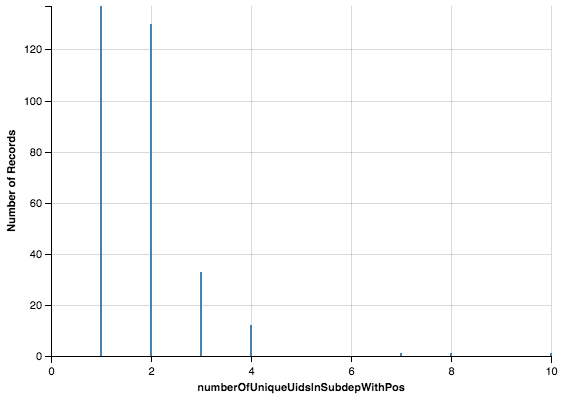

In [19]:
Chart(train_df.groupby(["subdepartmentId", "position"])["numberOfUniqueUidsInSubdepWithPos"].first().reset_index()).mark_bar().encode(
        x=X("numberOfUniqueUidsInSubdepWithPos"), 
        y="count(*)"
)

In [20]:
train_df = train_df.merge((train_df.groupby(["subdepartmentId", "date", "position"])["employeResult"]
                        .mean().reset_index()
                        .rename(columns={"employeResult": "avgEmployeResult"})), how="left", on=["subdepartmentId", "date", "position"])

In [33]:
train_df = train_df.assign(elyResultRelativeAvgPercent = lambda x: 100.0 * (x.avgEmployeResult - x.employeResult) / x.avgEmployeResult)

In [34]:
train_df.head(1)

,uid,employePlan,employeResult,percentage,numberOfChecks,avgCheck,date,cnt,sex,birthday,...,subdepartmentId,isManager,birthplace,position,name,departmentId,seniority,numberOfUniqueUidsInSubdepWithPos,avgEmployeResult,elyResultRelativeAvgPercent
0,u759,275400.0,419891.0,152.47,48,8748.0,2013-04-01,11,ж,1969-12-19,...,18799afd-7286-11e0-a872-001b789beaf2,0,Коломна,Продавец-кассир,Магазин60,52e63bd1-c1c4-11e1-abb2-001b789beaf2,731 days,3,419891.0,0.0


In [48]:
learning_offline_df = (pd.read_csv("../input/h_1_learning_offline.csv")
                         .rename(columns={"наименование программы": "course_name", 
                                          "Дата": "ldate", 
                                          "фактическое количество часов": "hours",
                                          "Оцека (если предусмотрена курсом)": "points",
                                          "uid тренера": "coach_uid"
                                         })
                         .assign(ldate = lambda x: pd.to_datetime(x.ldate, yearfirst=True, format="%Y.%m.%d", errors="coerce"))
                         .assign(course_name = lambda x: pd.Categorical(x.course_name))
                      ).dropna(axis=0, subset=["ldate"])


То что сотрудник прошел курс или нет можно в следующий раз установливать как то более хитро.

In [49]:
learning_offline_df["pass"] = 1

In [66]:
learning_offline_df = learning_offline_df.merge(train_df[["uid"]].groupby("uid").count().reset_index(), on="uid").head()

In [72]:
learning_offline_df.course_name.unique()

array(['Tefal_Знакомство с Компанией', 'Tefal: История бренда',
       'Tefal: продукт', 'Tefal: Технология дорогих продаж',
       'Обучение 1С. Кассир'], dtype=object)

In [69]:
uids_has_course

,uid,ldate
0,u1927,2014-02-18


In [68]:
courses = learning_offline_df.course_name.unique()
course = courses[0]
uids_has_course = learning_offline_df[learning_offline_df.course_name == course][["uid", "ldate"]]

In [88]:
learning_offline_df = learning_offline_df.drop(["is_webinar", "hours", "points", "coach_uid"], 1)

In [70]:
learning_offline_df.head()

,uid,course_name,is_webinar,ldate,hours,points,coach_uid,pass
0,u1927,Tefal_Знакомство с Компанией,0,2014-02-18,NaN,0,не установлен,1
1,u1927,Tefal: История бренда,0,2014-02-20,NaN,0,не установлен,1
2,u1927,Tefal: продукт,0,2014-02-19,NaN,0,не установлен,1
3,u1927,Tefal: Технология дорогих продаж,0,2014-02-21,NaN,0,не установлен,1
4,u1927,Обучение 1С. Кассир,0,2014-08-28,1,NaN,не установлен,1


In [94]:
learning_offline_df = pd.pivot_table(learning_offline_df, index=["uid", "date"], columns="course_name", values="pass", aggfunc=np.max).fillna(0)

In [97]:
learning_offline_df.loc["u1"]

course_name,"""БУДУЩЕЕ НАЧИНАЕТСЯ СЕГОДНЯ""",SV-Кассир,Tefal: История бренда,Tefal: Розничные технологии,Tefal: Технология дорогих продаж,Tefal: продукт,Tefal_Знакомство с Компанией,Адаптационное полевое обучение,Английский язык: УРОК 1,Английский язык: УРОК 2,...,УПРАВЛЕНЧЕСКИЙ КУРС: Основной управленческий цикл. день 2,УПРАВЛЕНЧЕСКИЙ КУРС: Управление конфликтами и профилактика стресса. день 1,УПРАВЛЕНЧЕСКИЙ КУРС: Управленческие коммуникации,Управленческие навыки,Установочный Тренинг (обкатка),Экскурсия,Экскурсия на выставку электроники,Экскурсия на завод бытовой техники,Электробезопасность,Эффективная коммуникации
date,,,,,,,,,,,,,,,,,,,,,
2011-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
